In [1]:
# import required libraries to munge data
import pandas as pd
import numpy as np
import os

In [2]:
# import matplotlib to draw plot inside of notebook
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
from math import log
def log_scale(list, base=2):
    """apply log2 function to all list item"""
    for i in range(len(list)):
        list[i] = log(list[i], base)
    return list

In [4]:
def create_subset_table(grid_table, measureType):
    
    subset_table = grid_table[grid_table["Measure Type"] == measureType]
    
    subset_table = pd.DataFrame(subset_table[["Step", "Epoch", "FILTER_SIZE", "CONV1_KERNELS", "CONV2_KERNELS", "FC1_UNITS", "Elapsed Time", "Test Error"]])
    subset_table = subset_table.sort_values(["Step", "FILTER_SIZE", "CONV1_KERNELS", "CONV2_KERNELS", "FC1_UNITS"], \
                                                    ascending=[True, True, True, True, True])
    subset_table = subset_table.reset_index(drop=True)

    #subset_table.describe()
    return subset_table

In [5]:
def create_best_error_table(best_list, total_only_table):
    merged_list = []
    no_total_list = []
    for best_condition in best_list:
        selection = {"FILTER_SIZE": best_condition["FILTER_SIZE"],\
                     "CONV1_KERNELS" : best_condition["CONV1_KERNELS"],\
                     "CONV2_KERNELS" : best_condition["CONV2_KERNELS"],\
                     "FC1_UNITS" : best_condition["FC1_UNITS"]}
        row = select_case(total_only_table, selection)        
        items = row.values.tolist()
        
        if len(items) >= 1:            
            item = items[0]            
            best_condition["Elapsed Time"] = row["Elapsed Time"].values.tolist()[0] 
            if item[5] > best_condition["Best Test Error"]:
                best_condition["Best Test Error"] = row["Test Error"].values.tolist()[0]  
        else:
            # print str(best_condition) # print out missing conditions in total_only_table 
            no_total_list.append(best_condition)
        merged_list.append(best_condition)
    merged_table = pd.DataFrame(merged_list)
    #merged_table.head(10)
    return [merged_table, no_total_list]

In [6]:
# Extract an one dimension
def get_one_dim(table, kv, selected_dim, output, log_x=True, log_y= True, plot=False):
    subset_table = table
    x_col = selected_dim
    for k in kv:
        subset_table = subset_table[subset_table[k] == kv[k]]
    
    if log_x: # log 2 transformation
        logscale_x = "log2(" + selected_dim + ")"
        subset_table[logscale_x] = log_scale(subset_table[selected_dim].values.tolist())
        x_col = logscale_x

    if log_y:  # log 10 transformation
        logscale_y = "log10(" + output + ")"
        subset_table[logscale_y] = log_scale(subset_table[output].values.tolist(), 10)
        output = logscale_y
        
    if plot:
        subset_table.plot(x=x_col, y=[output], figsize=(8, 8))
        
    return (subset_table)

In [7]:
def create_best_error_list(grid_table):
    # munge table to record best accuracy of hyperparameter vector which measured at each epochs
    epoch_table = grid_table[grid_table["Measure Type"] == "epoch"]

    best_list = []
    filter_sizes = set(grid_table['FILTER_SIZE'].values.tolist()) 
    conv1_depths = set(grid_table['CONV1_KERNELS'].values.tolist()) 
    conv2_depths = set(grid_table['CONV2_KERNELS'].values.tolist()) 
    fc_depths = set(grid_table['FC1_UNITS'].values.tolist()) 
    missing_list = []
    for filter_size in filter_sizes:
        for conv1_depth in conv1_depths:
            for conv2_depth in conv2_depths:
                for fc_depth in fc_depths:
                    selection = {"FILTER_SIZE": filter_size, "CONV1_KERNELS" : conv1_depth, \
                                 "CONV2_KERNELS" : conv2_depth, "FC1_UNITS" : fc_depth}
                    case = select_case(epoch_table, selection)
                    if len(case) == 0:
                        #print "missing case: " + str(selection)
                        missing_list.append(selection)
                    else:
                        best_test_error =  min(case["Test Error"])
                        best_case_row = case[case["Test Error"] == best_test_error]
                        epoch = best_case_row["Epoch"].tail(1).values.tolist()[0]
                        elapsed_time = best_case_row["Elapsed Time"].tail(1).values.tolist()[0]
                        best_case = {"FILTER_SIZE" : filter_size, "CONV1_KERNELS": conv1_depth, \
                                 "CONV2_KERNELS" : conv2_depth, "FC1_UNITS" : fc_depth, \
                                     "Best Test Error" : best_test_error,\
                                    "Epoch" : epoch, "Elapsed Time" : elapsed_time}
                        best_list.append(best_case)
    
    return [best_list, missing_list]

In [8]:
def select_partial_item(full_list):
    full_list.sort()
    result_list = []
    for i in range(len(full_list)):
        if i % 2 == 1:
            selected_item = full_list[i]
            result_list.append(selected_item)
    return result_list


In [9]:
def transform(data_list, n):
    x_list =[]
    y_list = []
    z_list = []
    for data in data_list:
        x_value = data[0]
        y_value = data[1]
        z_value = data[2]
        x_list.append(x_value)
        y_list.append(y_value)
        z_list.append(z_value)

#    print x_list
#    print y_list
#    print z_list

    X = [x_list[i:i+n] for i in range(0, len(x_list), n)]
    Y = [y_list[i:i+n] for i in range(0, len(y_list), n)]
    Z = [z_list[i:i+n] for i in range(0, len(z_list), n)]
#    print X
#    print Y
#    print Z
    return [X, Y, Z]

In [10]:
def generate_title(condition):
    title = ""
    for key in condition:
        if title != "":
            title = title + ", "
        title = title + str(key) + ": " + str(condition[key])
    return title

In [11]:
def draw_3dplots(x_key, x_values, y_key, y_values, col_key, col_values, row_key, row_values, z_key, postfix="", dpi=100):
    fig = plt.figure(figsize=(len(col_values) * 10, len(row_values) * 10), dpi=dpi)
    #fig.suptitle("Test error variation when model capacity hyperparameter changes", fontsize=50)
    index = 1
    for row in row_values:
        for col in col_values:
            condition = {row_key: row, col_key: col}
            ax = fig.add_subplot(len(row_values), len(col_values), index, projection='3d')
            ax.set_title(generate_title(condition))
            ax.set_xlim([0, max(x_values)])
            ax.set_ylim([0, max(y_values)])
            #print condition
            X, Y, Z = transform(
                generate_data_list(x_key, x_values, y_key, y_values, z_key, condition), 
                len(y_values))
            
            if z_key == "Test Error":
                ax.set_zlim([-2.5, 0])
                label = 'log(test error)'
            elif z_key == "Elapsed Time":                
                max_value = 60 # TODO:how to find the appropriate max value?
                ax.set_zlim([0, max_value])
                label = 'training time (min.)'
            else:
                ax.set_zlim([0, 0])
                label = 'error'           
  
            ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label=label)
            if index == 1:
                plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
                ax.set_xlabel(x_key)
                ax.set_xticklabels([])
                ax.set_ylabel(y_key)
                ax.set_yticklabels([])
            index += 1            

    plt.show()
    fig.savefig(z_key + "_3dplot_" + x_key + "-" + y_key + "-" + postfix + ".png", format='png', dpi=dpi, show=False)

In [12]:
merged_corr_table = pd.read_csv("../../log/correlation.csv", header=0)
merged_corr_table.head(5)

,Timestamp,Msec,Setting,Measure Type,Step,Epoch,Elapsed Time,Test Error,Validation Error,Training Error,BASE_LEARNING_RATE,CONV1_DEPTH,CONV2_DEPTH,DROPOUT_RATE,FC1_WIDTH,FILTER_SIZE,REGULARIZER_FACTOR
0,2016-11-29 21:08:16,206,/root/tf-hpolib/tf-hpo/src/.config/HPV_1480419...,epoch,859,1.0,8.15,0.8990,0.8922,NaN,0.1,50,50,0.25,896,3,0.00005
1,2016-11-29 21:08:16,230,/root/tf-hpolib/tf-hpo/src/.config/HPV_1480419...,epoch,859,1.0,8.17,0.8972,0.8960,NaN,0.1,50,50,0.75,896,3,0.02500
2,2016-11-29 21:08:16,233,/root/tf-hpolib/tf-hpo/src/.config/HPV_1480419...,epoch,859,1.0,8.17,0.8990,0.8922,NaN,0.1,50,50,0.75,896,3,0.00005
3,2016-11-29 21:08:20,990,/root/tf-hpolib/tf-hpo/src/.config/HPV_1480419...,epoch,1718,2.0,12.90,0.8972,0.8960,NaN,0.1,50,50,0.25,896,3,0.00005
4,2016-11-29 21:08:21,29,/root/tf-hpolib/tf-hpo/src/.config/HPV_1480419...,epoch,1718,2.0,13.00,0.9042,0.8974,NaN,0.1,50,50,0.75,896,3,0.02500


In [13]:
total_table = merged_corr_table[merged_corr_table["Measure Type"] == 'total']
total_table.rename(columns={"CONV1_DEPTH": "CONV1_KERNELS", "CONV2_DEPTH": "CONV2_KERNELS", "FC1_WIDTH": "FC1_UNITS"}, inplace=True)

total_table.describe()

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Msec,Step,Epoch,Elapsed Time,Test Error,Validation Error,Training Error,BASE_LEARNING_RATE,CONV1_KERNELS,CONV2_KERNELS,DROPOUT_RATE,FC1_UNITS,FILTER_SIZE,REGULARIZER_FACTOR
count,4469.000000,4469.0,4469.0,4469.000000,4469.000000,4469.000000,0.0,4469.000000,4469.000000,4469.000000,4469.000000,4469.000000,4469.000000,4469.000000
mean,491.334303,17180.0,20.0,247.958648,0.429542,0.427596,NaN,0.039297,100.581786,85.589617,0.500000,615.253524,7.636832,0.138154
std,285.794880,0.0,0.0,153.121200,0.429664,0.427753,NaN,0.040473,62.276435,60.616372,0.204854,294.395275,3.199974,0.218088
min,0.000000,17180.0,20.0,91.100000,0.005600,0.000000,NaN,0.000100,50.000000,50.000000,0.250000,128.000000,3.000000,0.000050
25%,242.000000,17180.0,20.0,137.000000,0.030500,0.029000,NaN,0.000100,50.000000,50.000000,0.250000,384.000000,5.000000,0.000050
50%,483.000000,17180.0,20.0,183.000000,0.074200,0.079600,NaN,0.010000,50.000000,50.000000,0.500000,640.000000,9.000000,0.000500
75%,737.000000,17180.0,20.0,322.000000,0.902000,0.895600,NaN,0.100000,150.000000,100.000000,0.750000,896.000000,11.000000,0.500000
max,999.000000,17180.0,20.0,744.000000,0.902000,0.896000,NaN,0.100000,250.000000,300.000000,0.750000,1024.000000,11.000000,0.500000


In [14]:
source_table = total_table

In [15]:
learning_rates = list(set(rate for rate in merged_corr_table["BASE_LEARNING_RATE"] ))
dropout_rates = list(set(rate for rate in merged_corr_table["DROPOUT_RATE"] ))
reg_factors = list(set(rate for rate in merged_corr_table["REGULARIZER_FACTOR"] ))
learning_rates.sort()
dropout_rates.sort()
reg_factors.sort()
print learning_rates
print dropout_rates
print reg_factors
reg_factors = [5.0000000000000002e-05, 0.00050000000000000001, 0.5]

[0.0001, 0.01, 0.050000000000000003, 0.10000000000000001]
[0.25, 0.5, 0.75]
[5.0000000000000002e-05, 0.00050000000000000001, 0.025000000000000001, 0.5]


In [16]:
def select_case(table, kv):
    subset_table = table
    for k in kv:
        subset_table = subset_table[subset_table[k] == kv[k]]
       
    return (subset_table)    

In [18]:
def get_z_value(x_name, x_value, y_name, y_value, z_name, condition, metric):
    condition[x_name] = x_value
    condition[y_name] = y_value
    #print condition
    result = select_case(source_table, condition)
    #print z_name
    #print str(result)
    value_list = result[z_name].values.tolist()
    if len(value_list) == 0:
        error_condition = condition
        error_condition[x_name] = x_value
        error_condition[y_name] = y_value
        print str(error_condition)
        value = 1
    else:
        if (len(value_list)) != 100:
            print str(condition) + " -> " + str(len(value_list)) 
        if metric == 'min':
            value = min(value_list)
        elif metric == 'max':
            value = min(value_list)
        elif metric == 'median':
            value = np.median(np.array(value_list))
        elif metric == '25p':
            value = np.percentile(np.array(value_list), 25)
        elif metric == '75p':
            value = np.percentile(np.array(value_list), 75)
        else:
            value = sum(value_list) / len(value_list)
    return value

In [39]:
def generate_data_list(x_key, x_values, y_key, y_values, z_key, condition, metric='mean'):
    data_list = []
    for x in x_values:
        for y in y_values:            
            data = []
            #print x_key  + " = " + str((x)) + ", " + y_key + " = " + str((y))           
            log_x = np.log10(x)
            log_y = np.log10(y)
            print x_key  + " = " + str((log_x)) + ", " + y_key + " = " + str((log_y))
            data.append(log_x)
            data.append(log_y)

            if z_key == "Test Error":
                z = log(get_z_value(x_key, x, y_key, y, z_key, condition, metric), 10)
            elif z_key == "Elapsed Time":
                z = get_z_value(x_key, x, y_key, y, z_key, condition, metric) / 60 # per minutes
            else:
                z = get_z_value(x_key, x, y_key, y, z_key, condition, metric)
            #print z
            data.append(z)
            data_list.append(data)
    return data_list

DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -1.0
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -4.0
{'DROPOUT_RATE': 0.5, 'REGULARIZER_FACTOR': 5e-05, 'BASE_LEARNING_RATE': 0.0001} -> 95
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -1.0
{'DROPOUT_RATE': 0.5, 'REGULARIZER_FACTOR': 5e-05, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 95
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -1.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.60205999132

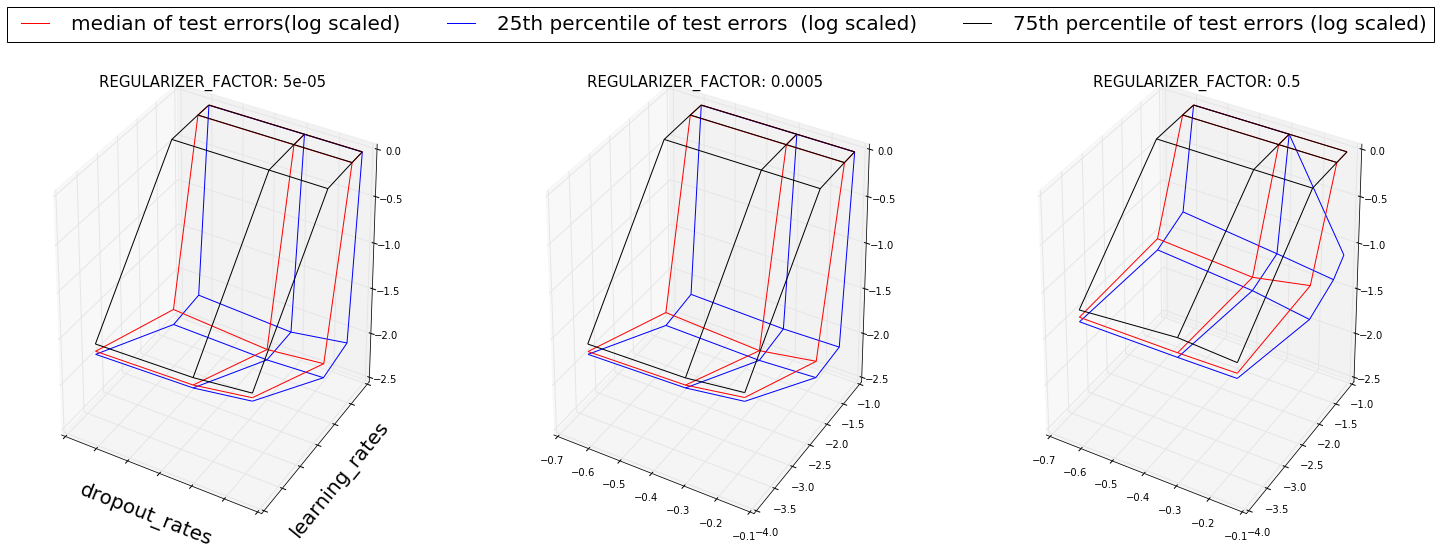

In [40]:

fig = plt.figure(figsize=(25, 30), dpi=100)
label='x: learning_rates, y: dropout_rates, z: log(test error)'
#fig.suptitle(label)
index = 1

for reg_factor in reg_factors:
    condition = {"REGULARIZER_FACTOR": reg_factor}
    ax = fig.add_subplot(3, 3, index, projection='3d')

    ax.set_title(generate_title(condition), fontsize=15)
    #ax.set_xlim([np.log2(0), np.log2(max(dropout_rates))])
    #ax.set_ylim([np.log2(0), np.log2(max((learning_rates)))])
    
    ax.set_zlim([-2.5, 0])
    median_dataset = generate_data_list("DROPOUT_RATE", dropout_rates, "BASE_LEARNING_RATE", learning_rates, \
                                           "Test Error", condition, "median")
    X, Y, Z = transform(median_dataset, len(learning_rates))
    ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = 'median of test errors(log scaled)', color='red')
    
    p25_dataset = generate_data_list("DROPOUT_RATE", dropout_rates, "BASE_LEARNING_RATE", learning_rates, \
                                           "Test Error", condition, "25p")
    X, Y, Z = transform(p25_dataset, len(learning_rates))
    ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '25th percentile of test errors  (log scaled)', color='blue')
    
    p75_dataset = generate_data_list("DROPOUT_RATE", dropout_rates, "BASE_LEARNING_RATE", learning_rates, \
                                           "Test Error", condition, "75p")
    X, Y, Z = transform(p75_dataset, len(learning_rates))
    ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '75th percentile of test errors (log scaled)', color='black')    

    if index == 1:
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, borderaxespad=0., fontsize=20)
        ax.set_xlabel('dropout_rates', fontsize=20)
        ax.set_xticklabels([])
        ax.set_ylabel('learning_rates', fontsize=20)
        ax.set_yticklabels([])
    index += 1

plt.show()
fig.savefig("3dplot_learning_rate-dropout.png", format='png', dpi=100, show=False)

DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -1.0
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -4.0
{'DROPOUT_RATE': 0.5, 'REGULARIZER_FACTOR': 5e-05, 'BASE_LEARNING_RATE': 0.0001} -> 95
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -1.0
{'DROPOUT_RATE': 0.5, 'REGULARIZER_FACTOR': 5e-05, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 95
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -1.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.60205999132

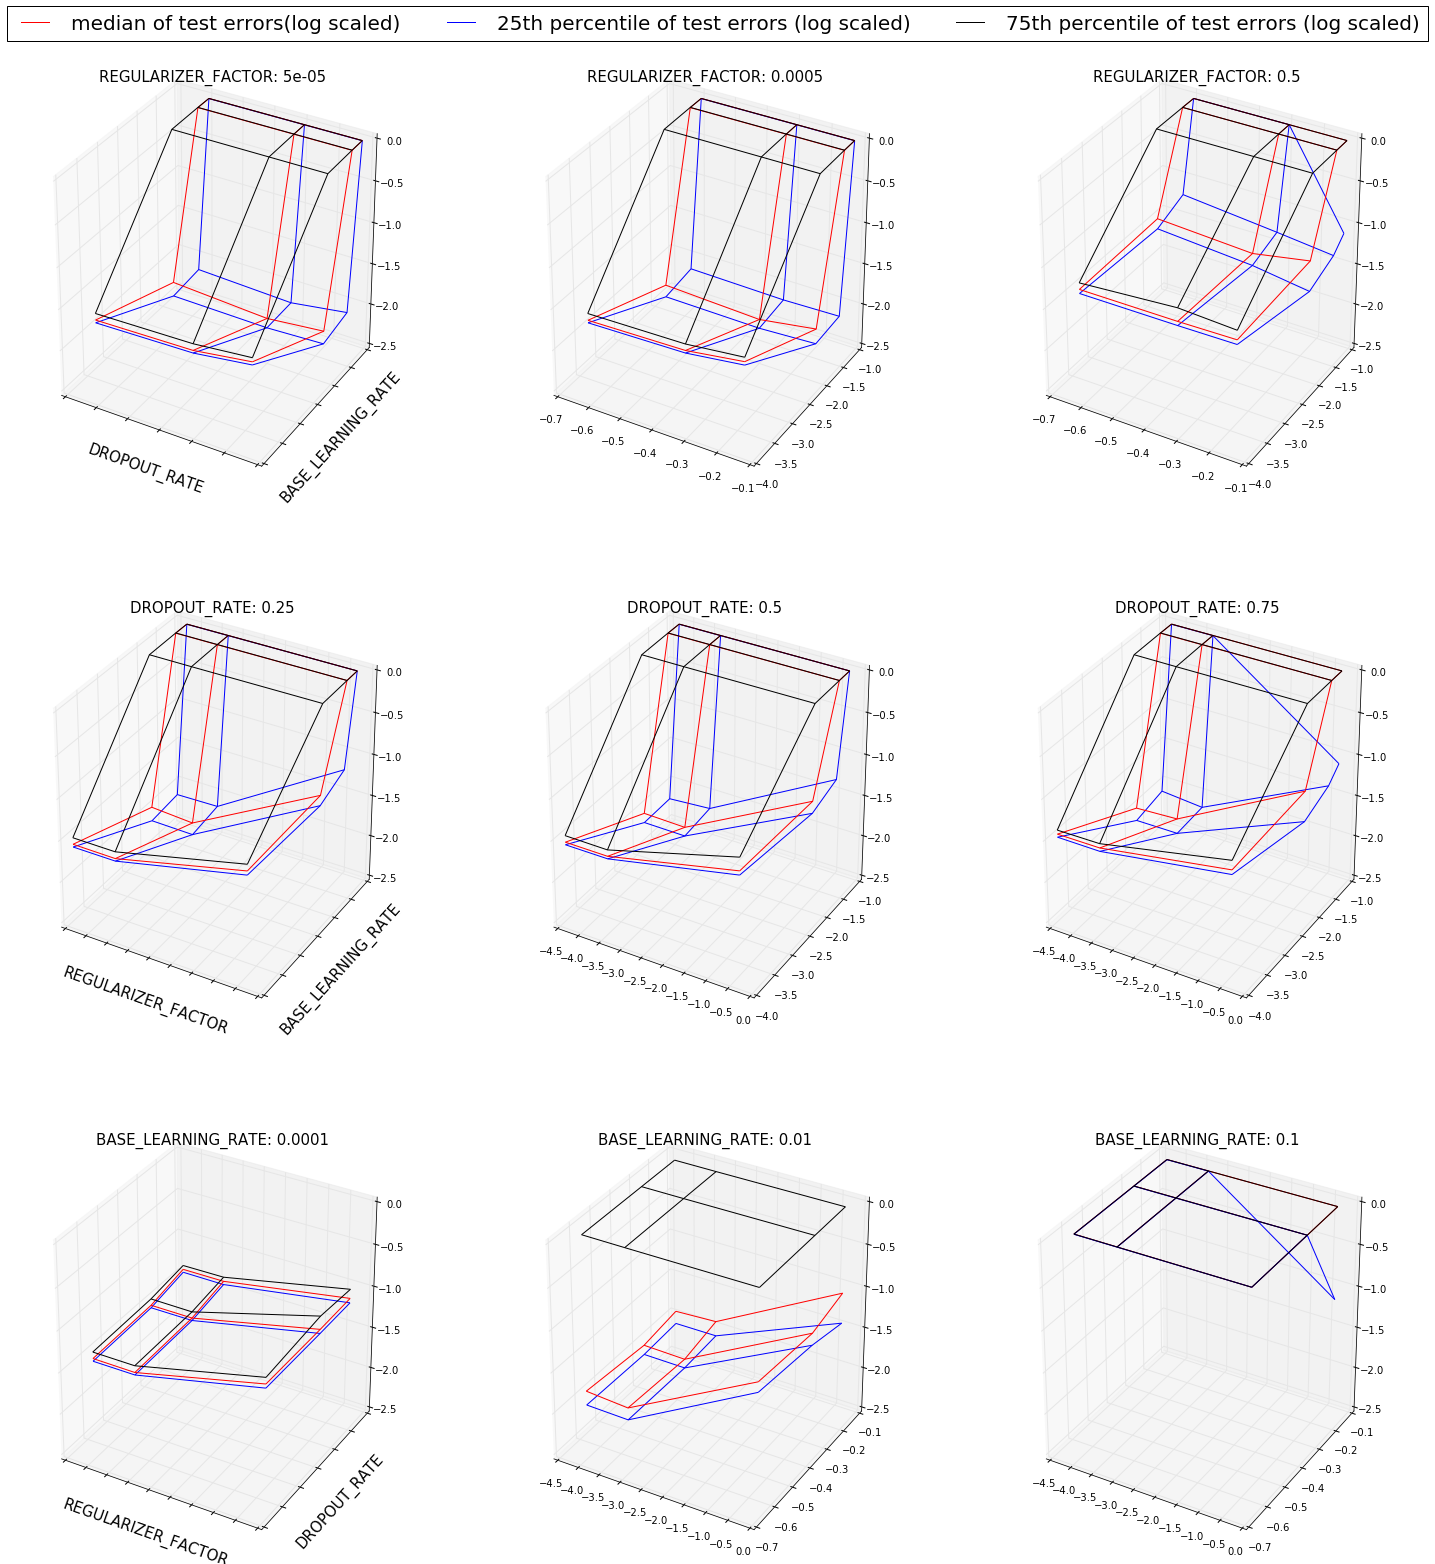

In [44]:
def draw_3dplots_in_low(fig, index, x_key, x_values, y_key, y_values, z_key, d_key, d_values):
    for dim in d_values:
        condition = {d_key: dim}
        ax = fig.add_subplot(3, 3, index, projection='3d')

        ax.set_title(generate_title(condition), fontsize=15)
        #ax.set_xlim([0, max(x_values)])
        #ax.set_ylim([0, max(y_values)])

        ax.set_zlim([-2.5, 0])
        median_dataset = generate_data_list(x_key, x_values, y_key, y_values, \
                                               z_key, condition, "median")
        X, Y, Z = transform(median_dataset, len(y_values))
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = 'median of test errors(log scaled)', color='red')
        p25_dataset = generate_data_list(x_key, x_values, y_key, y_values, \
                                               z_key, condition, "25p")
        X, Y, Z = transform(p25_dataset, len(y_values))
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '25th percentile of test errors (log scaled)', color='blue')
        p75_dataset = generate_data_list(x_key, x_values, y_key, y_values, \
                                               z_key, condition, "75p")
        X, Y, Z = transform(p75_dataset, len(y_values))
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '75th percentile of test errors (log scaled)', color='black') 
        if index == 1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, borderaxespad=0. , fontsize=20)
        if index % 3 == 1:
            
            ax.set_xlabel(x_key, fontsize=15)
            ax.set_xticklabels([])
            ax.set_ylabel(y_key, fontsize=15)
            ax.set_yticklabels([])
        index += 1
    return index

fig = plt.figure(figsize=(25, 27), dpi=100)
index = 1
index = draw_3dplots_in_low(fig, index, "DROPOUT_RATE", dropout_rates, "BASE_LEARNING_RATE", learning_rates, "Test Error", \
                            "REGULARIZER_FACTOR", reg_factors)
index = draw_3dplots_in_low(fig, index, "REGULARIZER_FACTOR", reg_factors, "BASE_LEARNING_RATE", learning_rates, "Test Error", \
                            "DROPOUT_RATE", dropout_rates)
index = draw_3dplots_in_low(fig, index, "REGULARIZER_FACTOR", reg_factors, "DROPOUT_RATE", dropout_rates,  "Test Error", \
                            "BASE_LEARNING_RATE", [0.0001, 0.01, 0.10000000000000001])
plt.show()
fig.savefig("3dplot_learning_params.png", format='png', dpi=100, show=False, bbox_inches='tight')

DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -1.0
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -4.0
{'DROPOUT_RATE': 0.5, 'REGULARIZER_FACTOR': 5e-05, 'BASE_LEARNING_RATE': 0.0001} -> 95
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.301029995664, BASE_LEARNING_RATE = -1.0
{'DROPOUT_RATE': 0.5, 'REGULARIZER_FACTOR': 5e-05, 'BASE_LEARNING_RATE': 0.10000000000000001} -> 95
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -2.0
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -1.30102999566
DROPOUT_RATE = -0.124938736608, BASE_LEARNING_RATE = -1.0
DROPOUT_RATE = -0.602059991328, BASE_LEARNING_RATE = -4.0
DROPOUT_RATE = -0.60205999132

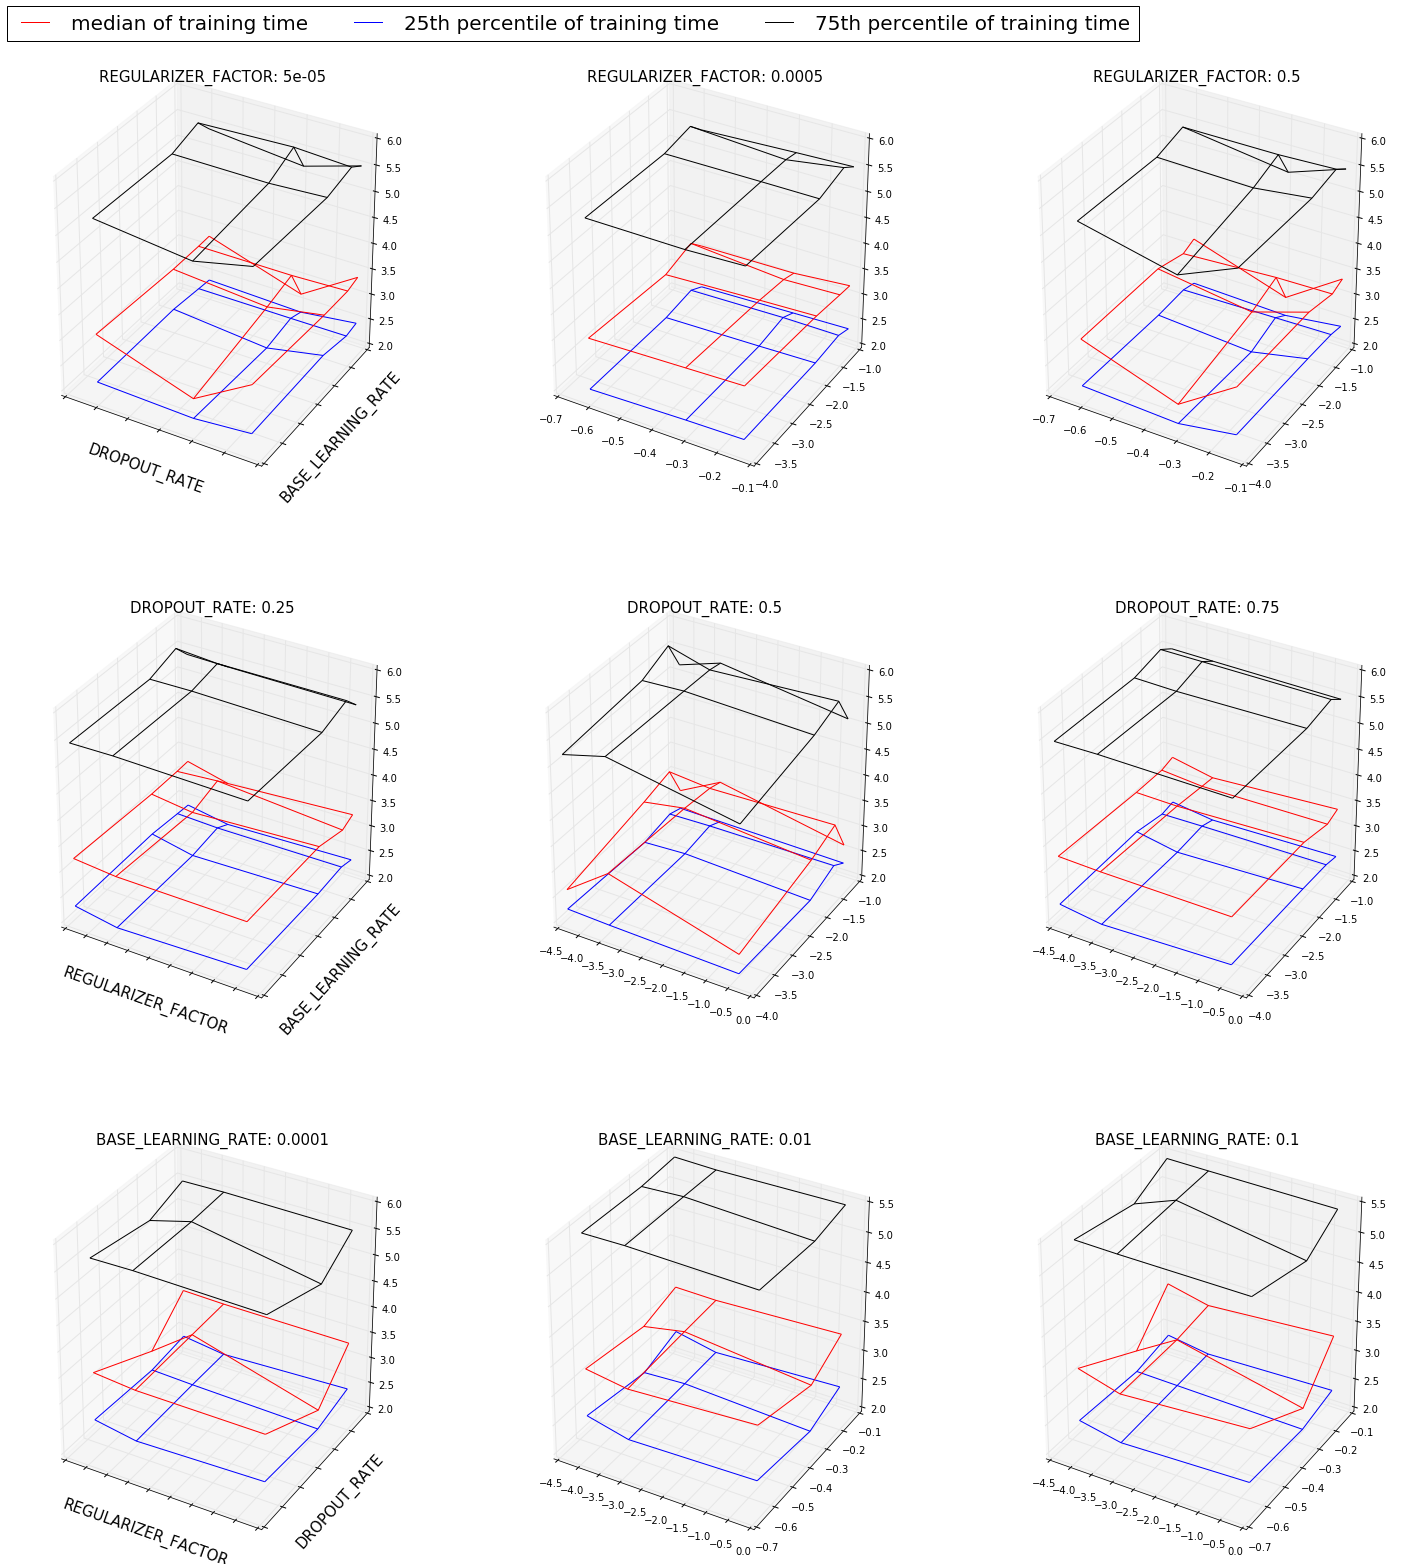

In [45]:
def draw_3dplots_in_low(fig, index, x_key, x_values, y_key, y_values, z_key, d_key, d_values):
    for dim in d_values:
        condition = {d_key: dim}
        ax = fig.add_subplot(3, 3, index, projection='3d')

        ax.set_title(generate_title(condition), fontsize=15)
        #ax.set_xlim([0, max(x_values)])
        #ax.set_ylim([0, max(y_values)])

        
        median_dataset = generate_data_list(x_key, x_values, y_key, y_values, \
                                               z_key, condition, "median")
        X, Y, Z = transform(median_dataset, len(y_values))
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = 'median of training time', color='red')
        p25_dataset = generate_data_list(x_key, x_values, y_key, y_values, \
                                               z_key, condition, "25p")
        X, Y, Z = transform(p25_dataset, len(y_values))
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '25th percentile of training time', color='blue')
        p75_dataset = generate_data_list(x_key, x_values, y_key, y_values, \
                                               z_key, condition, "75p")
        X, Y, Z = transform(p75_dataset, len(y_values))
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, label = '75th percentile of training time', color='black') 
        
        #ax.set_zlim([0, max()])
        if index == 1:
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, borderaxespad=0. , fontsize=20)
        if index % 3 == 1:
            
            ax.set_xlabel(x_key, fontsize=15)
            ax.set_xticklabels([])
            ax.set_ylabel(y_key, fontsize=15)
            ax.set_yticklabels([])
        index += 1
    return index

fig = plt.figure(figsize=(25, 27), dpi=100)
index = 1
index = draw_3dplots_in_low(fig, index, "DROPOUT_RATE", dropout_rates, "BASE_LEARNING_RATE", learning_rates, "Elapsed Time", \
                            "REGULARIZER_FACTOR", reg_factors)
index = draw_3dplots_in_low(fig, index, "REGULARIZER_FACTOR", reg_factors, "BASE_LEARNING_RATE", learning_rates, "Elapsed Time", \
                            "DROPOUT_RATE", dropout_rates)
index = draw_3dplots_in_low(fig, index, "REGULARIZER_FACTOR", reg_factors, "DROPOUT_RATE", dropout_rates,  "Elapsed Time", \
                            "BASE_LEARNING_RATE", [0.0001, 0.01, 0.10000000000000001])
plt.show()
fig.savefig("3dplot_learning_params_time.png", format='png', dpi=100, show=False, bbox_inches='tight')